In [223]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html
import torch

device='cuda:0'


opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.gpu_ids=[0]
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='vae_pix2pix2'
opt.netG='unet_2'
#opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
#opt.dataset_mode='sathei'
opt.name='0115_vae_sathei_all'
opt.norm='instance'
opt.input_nc=1

opt.output_nc=3
opt.preprocess="none"
opt.epoch = 'latest'
opt.attention = False
opt.useVAE2=False
opt.ngf=64

opt.use_bias_anyway= 1


model = create_model(opt)
model.setup(opt)
model.eval()
model.netG.eval()
model.netS.eval()
G=model.netG
S=model.netS


----------------- Options ---------------
                 add_real: False                         
             aspect_ratio: 1.0                           
                attention: False                         
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 1                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: Fal

In [ ]:
import torch
import json
import random
import string
import pathlib
import base64
import re
from io import BytesIO
from PIL import Image
from flask import Flask, request, send_file, redirect, render_template, Response
from flask_socketio import SocketIO
import numpy as np



app = Flask(__name__)



def delete_img():
    folder = "static/result"
    images = os.listdir(folder)
    if len(images) >= 20:
        for image in images[:10]:
            os.remove(os.path.join(folder, image))

import torchvision
cs=256
cs2=cs**2
scale=0.06
bias_r=0.4
transform=torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.to(device)),
    torchvision.transforms.Lambda(lambda x: (x[0]-bias_r+x[1]/cs+x[2]/cs2).unsqueeze(0).unsqueeze(0)),
    
    ]
)

@app.route("/", methods=["GET"])
def index():
    return 'Server avaliable'

def getImage(base64string):
    return transform(Image.open(BytesIO(base64.b64decode(re.sub('^data:image/.+;base64,', '', base64string)))).convert("RGB"))

def tensor2im_24(v, imtype=np.uint8):
#     print(v.shape)
    v = torch.clamp(v.data[0][0]+ bias_r,min=0)
    v=torch.stack([v- ((v * cs) % 1) / cs , ((v * cs) % 1) - (((v * cs2) % 1) / cs), (v * cs2) % 1], dim=0)
    image_numpy = v.cpu().float().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0
    return image_numpy.astype(imtype)

def tensor2im(v, imtype=np.uint8):
    v = v.data[0]
    image_numpy = v.cpu().float().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0
    return image_numpy.astype(imtype)



@app.route("/generate", methods=["POST"])
def generate():
    global X,Y,latent,sat
    delete_img()
    path = "static/result"
    pathlib.Path('static/result').mkdir(parents=True, exist_ok=True)
    X = getImage(request.json['structure'])
    bias=(X.min()+X.max())/2
    X=(X-bias)/scale
    
    latent = torch.cat([getImage(request.json['latent'][i])for i in range(4)],dim=1)*50
    h, w=latent.shape[2],latent.shape[3]
    
    output = G(torch.cat([X,latent],dim=1)).cpu()
    sat=torch.tanh(output[:,0:3])
    hei=output[:,3:4]
        
    hei_array = tensor2im_24(hei * scale + bias)
    hei_image = Image.fromarray(hei_array,"RGB")
    hei_name = ''.join(random.choice(string.ascii_lowercase) for i in range(6))+'.png'              
    hei_image.save(os.path.join(path, hei_name))
    
    sat_array = tensor2im(sat/2+0.5)
    sat_image = Image.fromarray(sat_array,"RGB")
    sat_name = ''.join(random.choice(string.ascii_lowercase) for i in range(6))+'.png'              
    sat_image.save(os.path.join(path, sat_name))
    
    resp = {
        'hei_path': path+'/'+hei_name,
        'sat_path': path+'/'+sat_name,
    }
    
    return Response(json.dumps(resp), mimetype="application/json")


socketio = SocketIO(app, cors_allowed_origins='*')
app.run(debug=False, host='0.0.0.0', port=81)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:81/ (Press CTRL+C to quit)
1.34.85.111 - - [17/Jan/2021 10:33:35] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:35] "GET /static/result/xxndgp.png HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:36] "GET /static/result/tzcnoh.png HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:39] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:39] "GET /static/result/vctqfq.png HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:39] "GET /static/result/wgkjjk.png HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:41] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:41] "GET /static/result/dvoqwg.png HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:41] "GET /static/result/qphbcj.png HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:43] "POST /generate HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:43] "GET /static/result/jnbpmc.png HTTP/1.1" 200 -
1.34.85.111 - - [17/Jan/2021 10:33:43] "GET /static/result

In [306]:
opt.dataroot='/home/host/data/training/height29_30km_pix2pix_sathei_all_med10/'
opt.dataset_mode='sathei'
opt.phase='val'
val_dataset = create_dataset(opt)
def blur(x,k):
    k=1/(k+0.0001)
    kernel_size = min(120,int(21/k))
    if kernel_size%2 ==0:kernel_size+=1
    arr = [
        [[x - kernel_size / 2 + 0.5, y - kernel_size / 2 + 0.5] for x in range(kernel_size)]
        for y in range(kernel_size)
    ]
    arr = torch.tensor(arr,device=x.device)
    kernel = (
        torch.exp(-0.015*k*k * (arr[:, :, 0] ** 2 + arr[:, :, 1] ** 2))
        .unsqueeze(0)
        .unsqueeze(0)
    )
    kernel/=kernel.sum()
    pad=torch.nn.ReplicationPad2d([(kernel_size-1)//2]*4)
    return torch.nn.functional.conv2d(pad(x), kernel)

dataset [SatHeiDataset] was created


In [307]:

from tqdm import tqdm
count={'Arge':0,'Cana':0,'Heng':0,'Hima':0,'Peru':0}
latent={'Arge':0,'Cana':0,'Heng':0,'Hima':0,'Peru':0}
latents={'Arge':[],'Cana':[],'Heng':[],'Hima':[],'Peru':[]}
for i,data in tqdm(enumerate(val_dataset)):
    name=data['A_paths'][0].split('/')[-1][:4]
    model.set_input(data)
    code=model.netS(torch.cat([blur(model.real_A,3),model.real_B,model.real_C],dim=1),0)
    latent[name]+=code[0,:,0,0].detach()
    latents[name].append(code[0,:,0,0].detach().cpu())
    count[name]+=1
for name,latent in latents.items():
    latents[name]=torch.stack(latent,dim=1)

632it [00:16, 37.75it/s]


In [308]:
import matplotlib.pyplot as plt

r=.2

def scat(X,label='',dimx=0,dimy=1):    
    plt.xlim(-r,r)
    plt.ylim(-r,r)    
    plt.xlabel('dim'+str(dimx))
    plt.ylabel('dim'+str(dimy))
    plt.scatter(X.t().cpu()[:,dimx],X.t().cpu()[:,dimy], alpha=0.4,edgecolors='none',label=label)
    plt.legend()

'   \nplt.figure(figsize=(6,6))\n\nfor name,latent in latents.items():    \n    if name in plot_name:\n        scat(latent,name,4,5)\n        \n        \nplt.figure(figsize=(6,6))\n\nfor name,latent in latents.items():    \n    if name in plot_name:\n        scat(latent,name,6,7)  \n        '

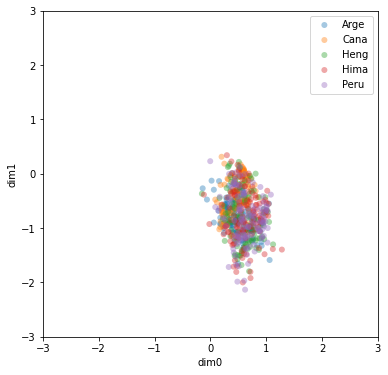

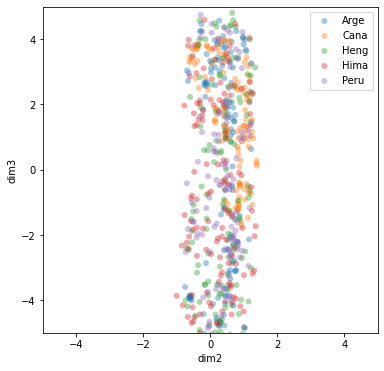

In [309]:
plot_name=['Arge','Cana','Heng','Hima','Peru']
plt.figure(figsize=(6,6))
r=3
for name,latent in latents.items(): 
    if name in plot_name:
        scat(latent,name,0,1)
r=5
plt.figure(figsize=(6,6))
for name,latent in latents.items(): 
    if name in plot_name:
        scat(latent,name,2,3)

'''   
plt.figure(figsize=(6,6))

for name,latent in latents.items():    
    if name in plot_name:
        scat(latent,name,4,5)
        
        
plt.figure(figsize=(6,6))

for name,latent in latents.items():    
    if name in plot_name:
        scat(latent,name,6,7)  
        '''

In [310]:
def p(x):
    plt.imshow(x.detach().cpu(),cmap='gray')
    plt.colorbar()
def pi(x):
    plt.imshow(x.detach().cpu()[0].transpose(0,2).transpose(0,1)/2+0.5)
    plt.colorbar()

In [331]:
for i,data in enumerate(val_dataset):
    if i==300:
        break

In [362]:
name=data['A_paths'][0].split('/')[-1][:4]
model.set_input(data)
latent=model.netS(torch.cat([blur(model.real_A,3),model.real_B,model.real_C],dim=1),0)
output = model.netG(torch.cat([X*3,latent],dim=1)).cpu()
sat=torch.tanh(output[:,0:3])
hei=output[:,3:4]

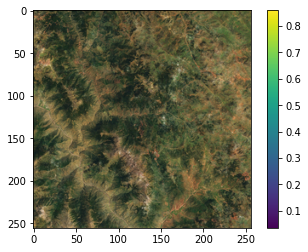

In [363]:
pi(model.real_B)

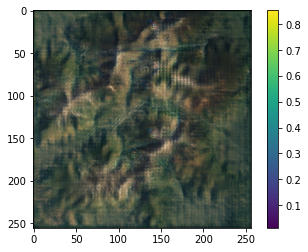

In [364]:
pi(sat)

In [315]:
X=model.real_A

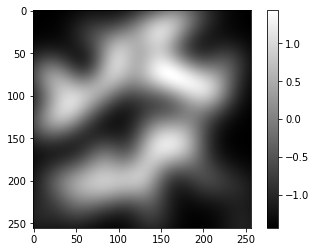

In [349]:
p(X[0,0])

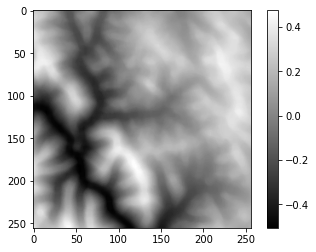

In [339]:
p(model.real_A[0,0])

In [134]:
torch.var(torch.tensor([[1,2.]]))

tensor(0.5000)

In [261]:
latent

tensor([[[[ 0.8222,  0.8226,  0.8231,  ...,  0.4360,  0.4364,  0.4369],
          [ 0.8226,  0.8231,  0.8235,  ...,  0.4362,  0.4366,  0.4371],
          [ 0.8230,  0.8235,  0.8239,  ...,  0.4364,  0.4368,  0.4373],
          ...,
          [ 0.4448,  0.4450,  0.4452,  ...,  0.2637,  0.2639,  0.2641],
          [ 0.4452,  0.4454,  0.4456,  ...,  0.2639,  0.2641,  0.2643],
          [ 0.4457,  0.4459,  0.4461,  ...,  0.2641,  0.2643,  0.2645]],

         [[-0.6550, -0.6549, -0.6547,  ..., -0.7916, -0.7915, -0.7913],
          [-0.6558, -0.6557, -0.6555,  ..., -0.7927, -0.7926, -0.7924],
          [-0.6566, -0.6565, -0.6563,  ..., -0.7938, -0.7936, -0.7935],
          ...,
          [ 0.0363,  0.0362,  0.0361,  ...,  0.1304,  0.1303,  0.1302],
          [ 0.0355,  0.0354,  0.0353,  ...,  0.1293,  0.1292,  0.1291],
          [ 0.0347,  0.0346,  0.0345,  ...,  0.1282,  0.1281,  0.1280]],

         [[-0.3191, -0.3204, -0.3217,  ...,  0.7698,  0.7685,  0.7672],
          [-0.3203, -0.3216, -

In [18]:
model.netS.module.upsampler(latent[0][0:16].view(1,1,4,4)).shape

NameError: name 'model' is not defined

In [19]:
slider = torch.tensor([[0.]*10]).float()
slider[0,0] = 1
slider[0,1] = -1
latent = torch.mm(U,slider.t())


In [119]:
14432664

0.30000000000000004

In [212]:
model.forward(latent)

tensor([[0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], dtype=torch.float64)

In [14]:
model.netG.eval()
model.netG.module.training

False

In [18]:
import torch
model.set_input(data)
model.forward(torch.tensor([[-0.0010],
        [ 0.5],
        [-0.0356],
        [-0.0015],
        [-0.0081],
        [ 0.0255],
        [0.3],
        [ 0.0295],
        [-0.0169],
        [-0.0107],
        [ 0.1654],
        [0.5],
        [ 0.0121],
        [-0.3842],
        [ 0.0416],
        [ 0.3695]]*16, dtype=torch.float).cuda())

In [22]:
import torchvision
def p(x):
    return torchvision.transforms.ToPILImage()(x[0].detach().cpu()/2+0.5)

In [23]:
p(model.get_current_visuals()['fake_B'])

NameError: name 'model' is not defined

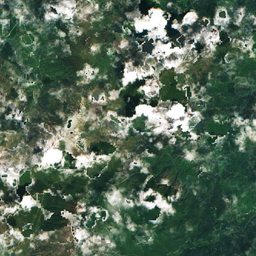

In [254]:
p(model.get_current_visuals()['real_B'])

In [25]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html

opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='vae_pix2pix'
opt.netG='unet_256'
opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
opt.dataset_mode='aligned'
opt.name='1026_vae_sat_all'
opt.norm='batch'
opt.input_nc=1
opt.output_nc=3
opt.preprocess=[]
sat_model = model.create_model(opt)
sat_model.setup(opt)

opt.phase='train'
train_dataset = create_dataset(opt)
opt.phase='val'
val_dataset = create_dataset(opt)
opt.phase='test'
test_dataset = create_dataset(opt)
from tqdm import tqdm
mius_sat=[]
model=sat_model
model.eval()

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                             	[default: 0]
 

NameError: name 'model' is not defined

In [15]:
torch.nn.Sigmoid()

Sigmoid()

In [17]:
nn=torch.nn
class S(nn.Module):
    def __init__(self):
        super(S,self).__init__()

In [19]:
s=S()

In [22]:
seq=nn.Sequential(s,nn.Conv2d(1,1,1))

In [28]:
list(seq.children())[0].t

123

In [27]:
s.t=123